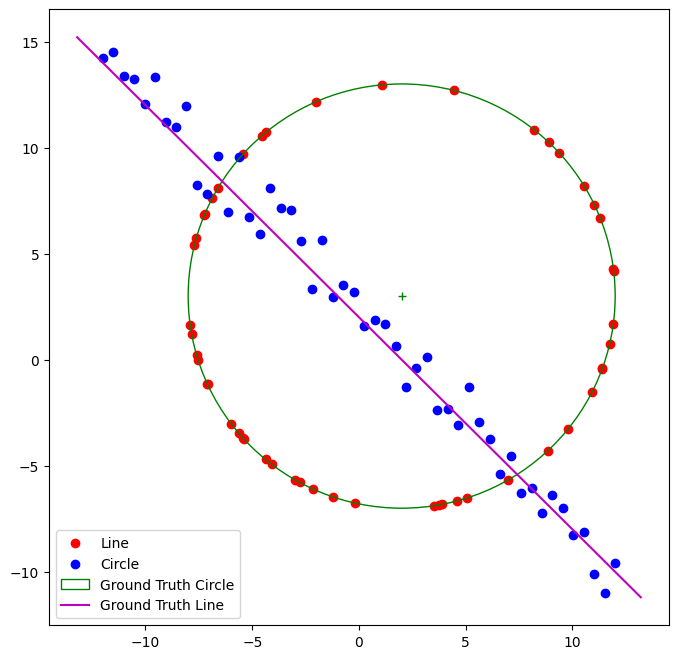

In [23]:
from scipy.optimize import minimize
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
#import tikzplotlib

np.random.seed(0)
N=100 #number of points
half_n=N//2 #number of points allocated to each class
#circle parameters
r=10 #radius
x0_gt,y0_gt = 2,3 #center
s =r/16 #standard deviation
t=np.random.uniform(0,2*np.pi,half_n) #angle
n = np.random.randn(half_n) #noise
x,y=x0_gt+r*np.cos(t),y0_gt+r*np.sin(t) #points on circle x^2+y^2=r^2 parametric form
X_circ = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1))) #circle points; 2 column arrays horizzontal concatanation
s=1
#line parameters
m,b=-1,2 #slope and intercept
x=np.linspace(-12,12,half_n) #points on line x axis
y= m*x+b+s*np.random.randn(half_n) #points on line y=mx+b
X_line = np.hstack((x.reshape(half_n,1),y.reshape(half_n,1))) #line points
X=np.vstack((X_circ,X_line)) #all points on line and circle vertically concatanated

#plotting noisy data

fig,ax=plt.subplots(1,1,figsize=(8,8)) 
ax.scatter(X_circ[:,0],X_circ[:,1],c='r',label='Line') #plotting line points in red
ax.scatter(X_line[:,0],X_line[:,1],c='b',label='Circle') #plotting circle points in blue

circle_gt=plt.Circle((x0_gt,y0_gt),r,color='g',fill=False,label='Ground Truth Circle') #plotting ground truth circle in green
ax.add_patch(circle_gt) #adding ground truth circle to plot
ax.plot((x0_gt),(y0_gt),'+',color='g') #plotting centre of ground truth circle
x_min,x_max = ax.get_xlim() #getting x limits
x_ =np.array([x_min,x_max]) #x values for plotting ground truth line
y_ = m*x_+b #y values for plotting ground truth line
plt.plot(x_,y_,color='m',label='Ground Truth Line') #plotting ground truth line in magenta
plt.legend()
plt.show()

.....................................RANSAC LINE FITTING............................................
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.6928342344745788e-09
            Iterations: 8
            Function evaluations: 36
            Gradient evaluations: 8
Iteration 1:
Estimated Model Parameters (a, b, d): [0.86142362 0.50788714 4.45981538]
Number of Inliers: 12
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.3193871716309348e-08
            Iterations: 5
            Function evaluations: 24
            Gradient evaluations: 5
Iteration 2:
Estimated Model Parameters (a, b, d): [0.77959511 0.62628385 1.1928919 ]
Number of Inliers: 29
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.519526884167972e-10
            Iterations: 8
            Function evaluations: 35
            Gradient evaluations: 8
Iteration 3:
Estimated Model Parameters (a, b, d

IndexError: list index out of range

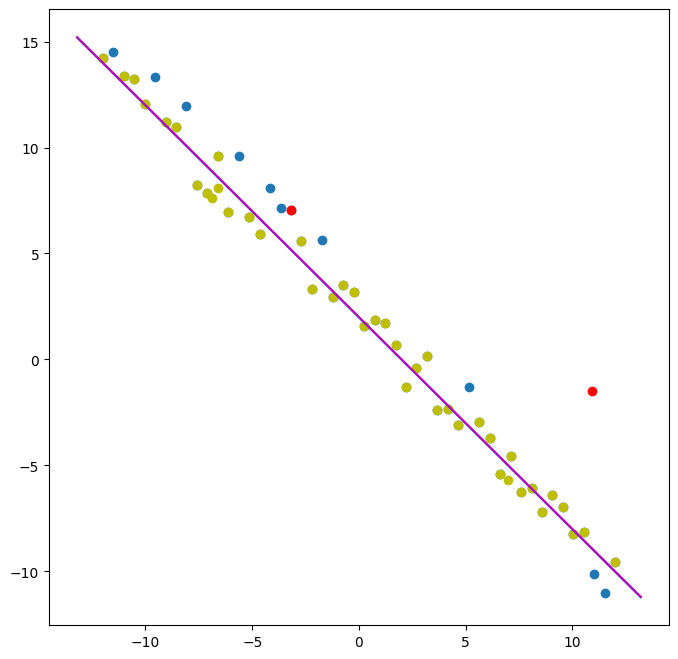

In [42]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

N = X.shape[0] #number of points for line fitting
X_ = X #points for line fitting



#(a)........................................RANSAC LINE FITTING.............................................

print(".....................................RANSAC LINE FITTING............................................")
l_threshold = 1.   # Threshold value to determine data points that are fit well by model.
l_max_iterations = 100
l_data_points = 0.4*N   # Number of close data points required to assert that a model fits well to data.
l_estimate_data_points = 2       # Minimum number of data points required to estimate model parameters.
l_best_error = np.inf

l_inliers_line = []        # Indinces of the inliers
l_best_model_line = []     # Best model normal (a, b) and distance from origin d
l_best_sample_line = []    # Three-point sample leading to the best model computation
l_res_only_with_sample = [] # Result (a, b, d) only using the best sample
l_best_inliers_line = []   # Inliers of the model computed form the best sample


# RANSAC to fit a line
#function to create random sample of 2 points from the datalist X_
def sample_points(X,n):
    indices = np.random.randint(0, N, n) #randomly selecting n indices from 0 to N
    return X_[indices,:] #returning n points from X_ with the selected indices

# hypothesize a model function to fit a line to the sample points; RANSAC to fit a line
def line_model(x, indices):
    a,b,d = x[0],x[1],x[2] #model parameters
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d)) #sum of squared distances of all points from the line
    
def line_constraint(x):
    # Extract the model parameters
    a, b = x[0], x[1]
    # Apply the constraint ∥[a, b]⊺∥ = 1
    return np.linalg.norm([a, b]) - 1

cons = ({'type': 'eq', 'fun': line_constraint}) #constraint on the model parameters

#compute error function

# Set of inliers (consensus)
def consensus_line(X, x, l_threshold):
    a, b, d = x[0], x[1], x[2] #line model parameters
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d) #absolute distance of all points from the line
    return error < l_threshold #returning indices of points with distance less than threshold


l_iteration = 0
while l_iteration < l_max_iterations:   
    # Randomly select 2 data points for the sample
    indices = np.random.randint(0, N, l_estimate_data_points)
    x0 = np.array([1, 1, 0])  # Initial estimate
    res = minimize(fun=line_model, args=indices, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})

    # Compute inliers based on the optimized model
    l_inliers_line = consensus_line(X_, res.x, l_threshold)

    # Print iteration details
    print(f'Iteration {l_iteration + 1}:')
    print(f'Estimated Model Parameters (a, b, d): {res.x}')
    print(f'Number of Inliers: {l_inliers_line.sum()}')

    if l_inliers_line.sum() > l_data_points:
        x0 = res.x 
        # Refine the model using inliers
        res = minimize(fun=line_model, args=l_inliers_line, x0=x0, tol=1e-6, constraints=cons, options={'disp': True})

        if res.fun < l_best_error:
            print(f'A better model found: (a, b, d) = {res.x}, Error = {res.fun}')
            l_best_model_line = res.x
            best_error = res.fun
            l_best_sample_line = sample_points(X_, l_estimate_data_points)
            l_res_only_with_sample = x0
            l_best_inliers_line = l_inliers_line

    l_iteration += 1

print('\nBest Line Model:')
print(f'(a, b, d) = {l_best_model_line}')
print(f'Error = {best_error}')

print('Best line model', l_best_model_line)






#(b)........................................RANSAC CIRCLE FITTING.............................................

print(".....................................RANSAC CIRCLE FITTING............................................")

c_threshold = 1.
c_max_iterations = 100
c_data_points = 0.6*N   # Number of close data points required to assert that a model fits well to data.
c_estimate_data_points = 3       # Minimum number of data points required to estimate model parameters.
c_best_error = np.inf

c_inliers =[]
c_best_model = []
c_best_inliers = []
c_best_sample= []
c_res_only_with_sample = []

#(b)Subtracting the inliers of the line from the data points to get the points on the circle
line_outliers = np.where(l_best_inliers_line==False)[0]
remnants = np.array([X[line_outliers[i]] for i in range(len(line_outliers))])
print('remnants',len(remnants))

#function to create random sample of 3 points on corcle from the datalist remenants
    
def sample_points_circle(X,n):
    c_indices = np.random.randint(0, N1, n) #randomly selecting n indices from 0 to N
    return c_indices #returning n points from X_ with the selected indices

# hypothesize a model function to fit a circle to the sample points; RANSAC to fit a circle
def circle_model(x, indices):
    x0, y0, r = x
    x1, y1 = remnants[indices].T
    return np.sum((np.sqrt((x1 - x0)**2 + (y1 - y0)**2) - r)**2)

# Constraints 
def g(x): 
    return x[0]**2 + x[1]**2 - 1 

cons1 = ({'type': 'eq', 'fun': g})


'''If g(x) equals 0, it means the point x lies exactly on the circle's boundary.
If g(x) is less than 0, it means the point x is inside the circle.
If g(x) is greater than 0, it means the point x is outside the circle.'''

# Set of inliers (consensus)
def consenus_circle(remnants, x, c_threshold):
    distances = np.abs(np.linalg.norm(remnants - x[:2], axis=1) - x[2])
    # Count number of inliers
    return distances < c_threshold

c_iteration = 0
while c_iteration < c_max_iterations:
    c_indices = np.random.randint(0,len(remnants), c_estimate_data_points)
    c0 = np.array([0,0,0]) #initial guess
    res = minimize(circle_model, c0, args=c_indices, tol=1e-6,constraints=cons1) #minimize the error
    c_inliers = consenus_circle(remnants, res.x, c_threshold)  #find the consensus set

    # Print iteration details
    print(f'Iteration {c_iteration + 1}:')
    print(f'Estimated Model Parameters (x0, y0, r): {res.x}')
    print(f'Number of Inliers: {np.sum(c_inliers)}')
    if np.sum(c_inliers) > c_data_points:
            r0 = res.x
            res = minimize(circle_model, x0=r0, args=(c_inliers),tol= 1e-6,constraints=cons1)
            if res.fun < c_best_error:
                print(f'A better model found: (x0, y0, r) = {res.x}, Error = {res.fun}')
                c_best_error = res.fun
                c_best_sample= sample_points_circle(remnants, c_estimate_data_points)
                c_best_model = res.x
                c_best_inliers = c_inliers

    c_iteration += 1


print('\nBest Circle Model:')
print(f'(x0, y0, r) = {c_best_model}')
print(f'Error = {c_best_error}')




fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='Line points')
ax.scatter(X_[l_best_inliers_line,0],X_[l_best_inliers_line,1], color='y', label='Inliers Line')
ax.scatter(l_best_sample_line[:,0],l_best_sample_line[:,1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-l_best_model_line[1]*x_ + l_best_model_line[2])/l_best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

ax.scatter(remnants[c_best_inliers,0],remnants[c_best_inliers,1],color='c',label='Inliers Circle')
ax.scatter(remnants[c_best_sample,0],remnants[c_best_sample,1],color='k',label='Best samples for circle')
circle = plt.Circle((c_best_model[0],c_best_model[1]),c_best_model[2],color='m',fill=False,label='RANSAC Circle')
ax.add_patch(circle)

plt.legend()
